/var/folders/m1/tx6ck0f962jd1hq4ch5phg_80000gn/T/ipykernel_63334/3121163745.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
/var/folders/m1/tx6ck0f962jd1hq4ch5phg_80000gn/T/ipykernel_63334/3121163745.py:89: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


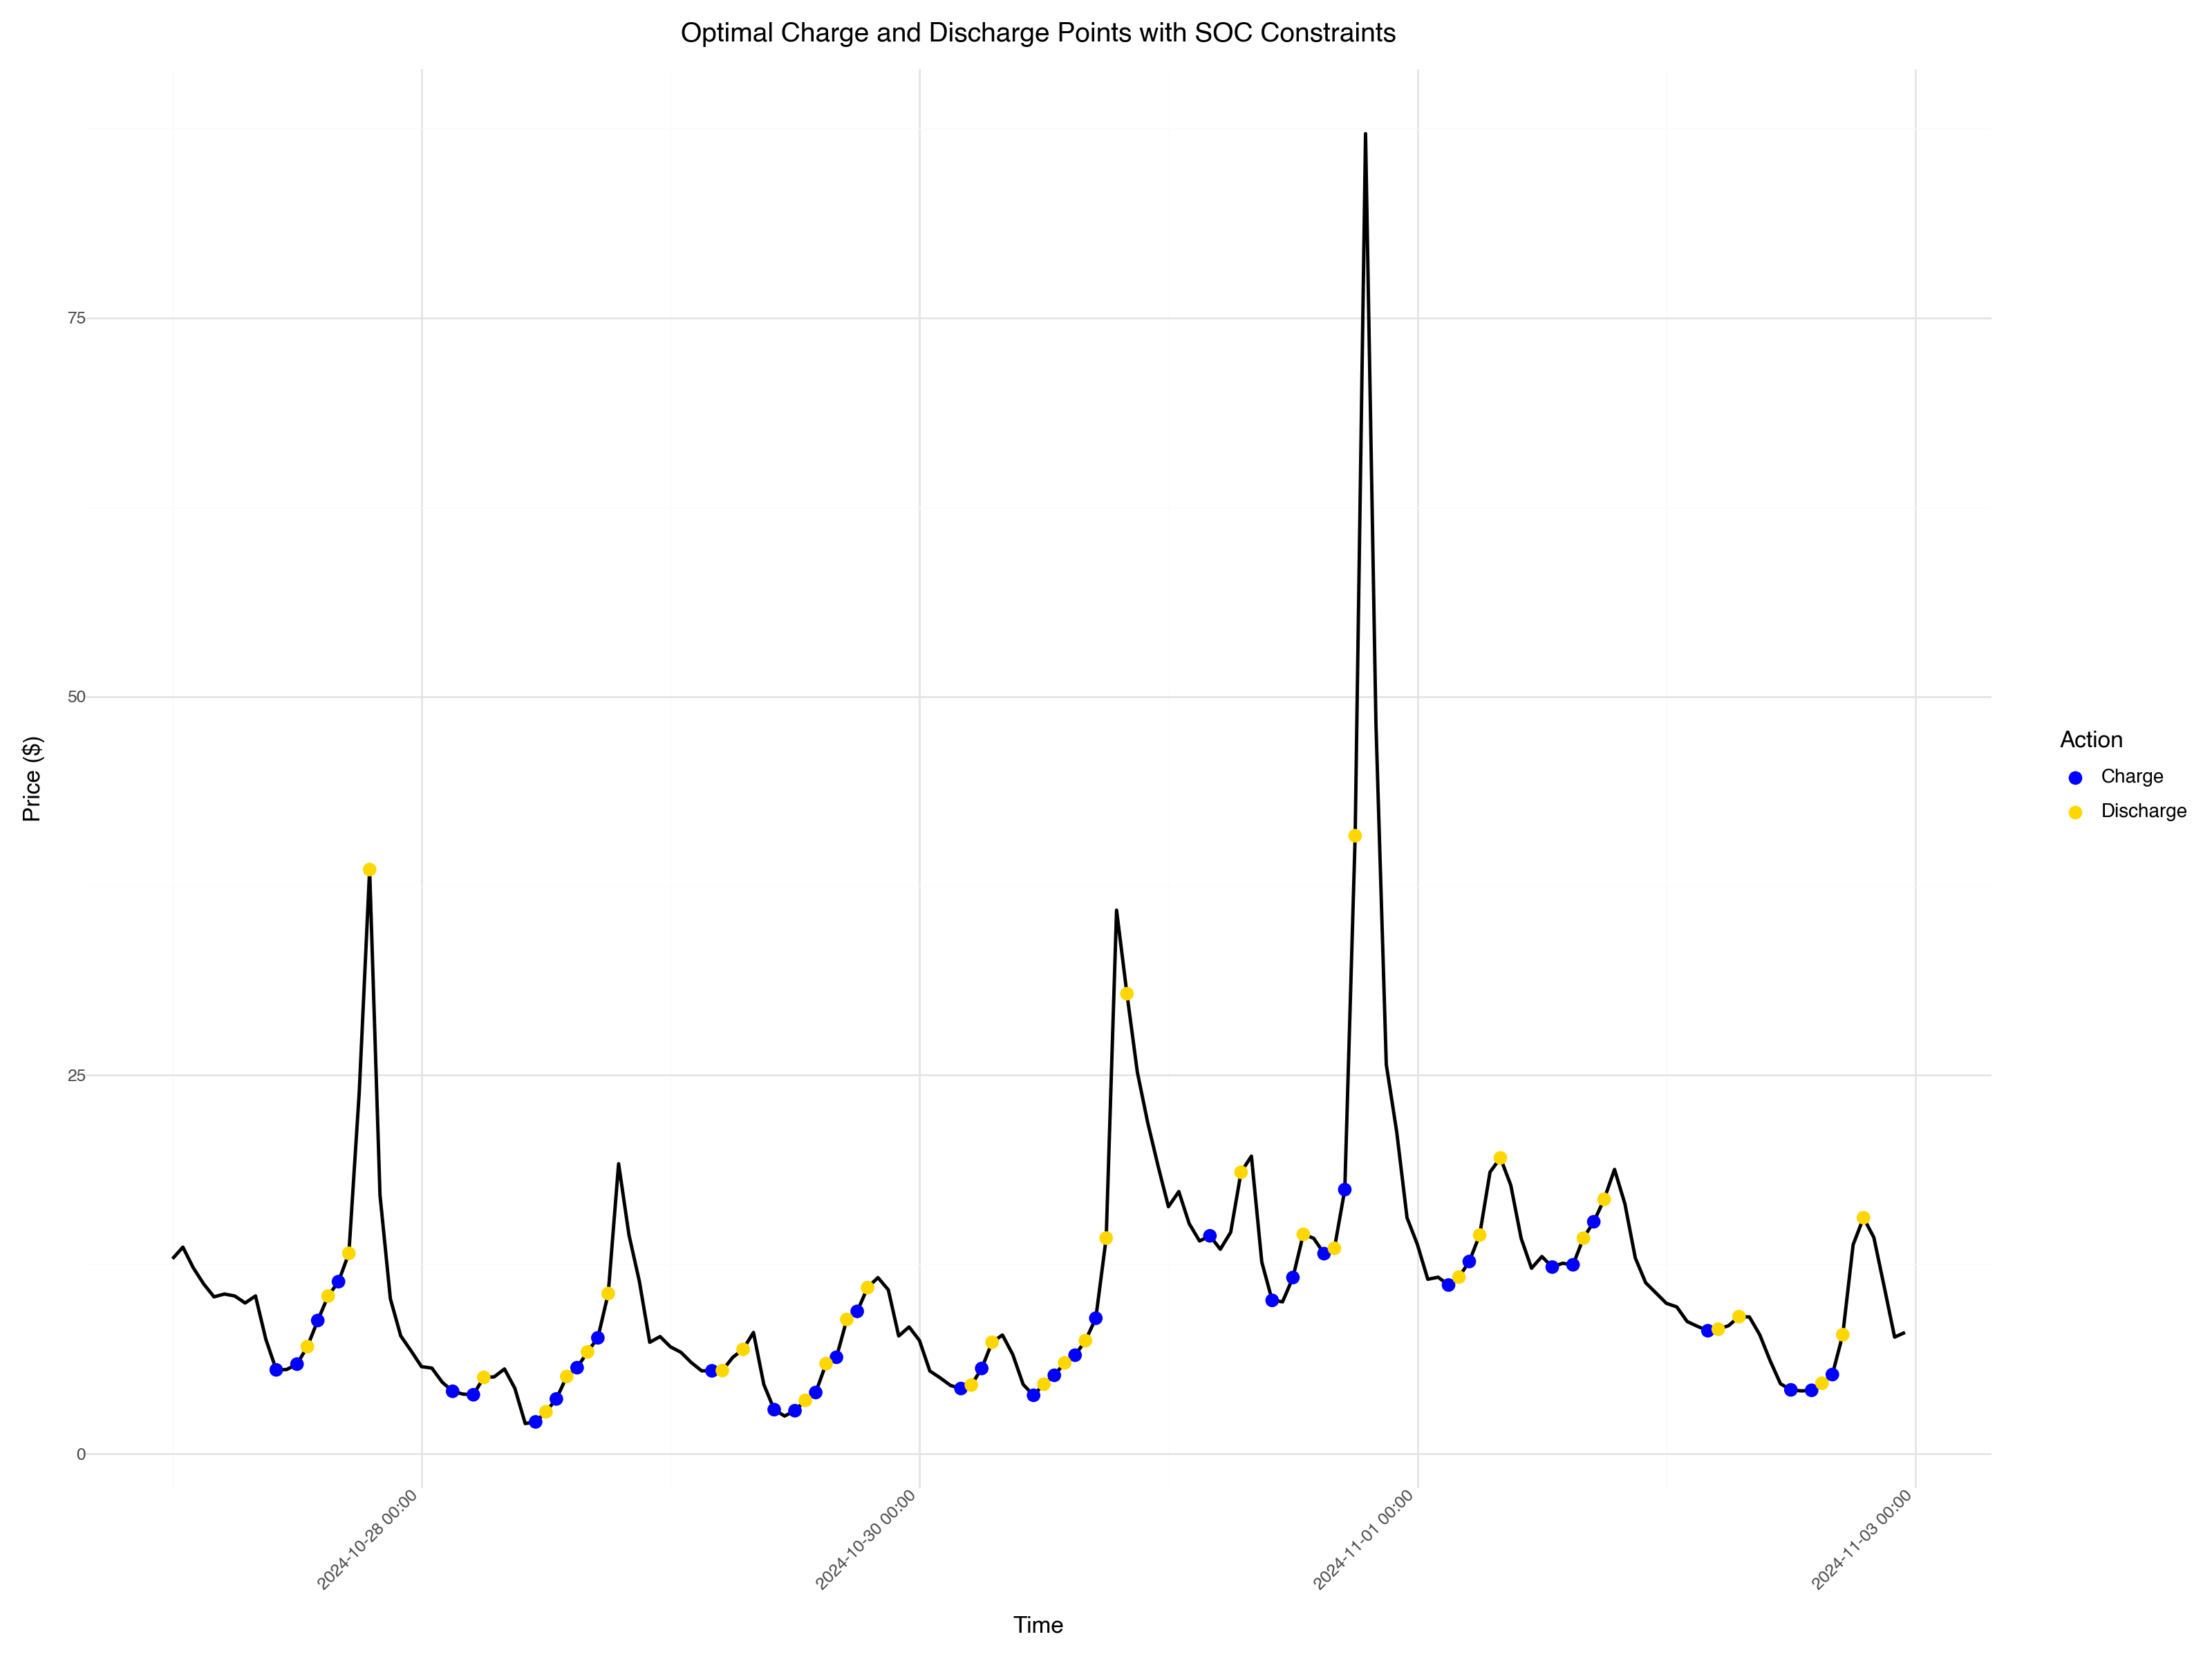

In [ ]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_minimal, theme, element_text, scale_x_datetime, scale_color_manual

# Load the CSV file
df = pd.read_csv('price.csv')

# Extract the 'Avg. Energy Settlement Point Price' column
prices = df['Avg. Energy Settlement Point Price'].tolist()

# Generate datetime points from Nov 3, 2024 00:00 to Nov 9, 2024 23:00 (hourly intervals)
start_time = pd.Timestamp("2024-10-27 00:00")
time_series = pd.date_range(start=start_time, periods=len(prices), freq='H')

# Function to find optimal charge and discharge points with SOC constraints
def find_optimal_points(prices, battery_duration=2, soc_min=20, soc_max=80, initial_soc=50):
    n = len(prices)
    soc = initial_soc  # Start SOC at 50%
    optimal_charge = []
    optimal_discharge = []

    for i in range(n - battery_duration + 1):
        charge_price = np.mean(prices[i:i + battery_duration])  # Avg price over charge duration
        discharge_price = np.mean(prices[i + battery_duration:i + 2 * battery_duration])  # Avg discharge price

        # Ensure we do not exceed SOC max when charging
        if charge_price < discharge_price and soc + 20 <= soc_max:
            optimal_charge.append(i)
            soc += 20  # Assume each charge cycle adds 20% SOC

        # Ensure we do not go below SOC min when discharging
        elif charge_price < discharge_price and soc - 20 >= soc_min:
            optimal_discharge.append(i + battery_duration)
            soc -= 20  # Assume each discharge cycle reduces SOC by 20%

    return optimal_charge, optimal_discharge

# Find optimal charge and discharge points
charge_points, discharge_points = find_optimal_points(prices)

# Convert indices to datetime
charge_times = [time_series[i] for i in charge_points]
discharge_times = [time_series[i] for i in discharge_points]

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Time': time_series,
    'Price': prices
})

# Add charge and discharge points to the DataFrame
plot_data['Charge'] = np.nan
for i in charge_points:
    plot_data.loc[i, 'Charge'] = prices[i]

plot_data['Discharge'] = np.nan
for i in discharge_points:
    plot_data.loc[i, 'Discharge'] = prices[i]

# Reshape the data for plotting with a categorical variable
plot_data_long = pd.melt(plot_data, id_vars=['Time', 'Price'], value_vars=['Charge', 'Discharge'],
                         var_name='Action', value_name='Action_Price')

# Plot using plotnine with a minimal theme, updated colors, and figure size (16, 12)
plot = (
    ggplot(plot_data_long, aes(x='Time', y='Price'))
    + geom_line(color='black', size=1)  # Price curve in black
    + geom_point(aes(y='Action_Price', color='Action'), size=3, na_rm=True)  # Charge and discharge points with color mapping
    + labs(
        x='Time',
        y='Price ($)',
        title='Optimal Charge and Discharge Points with SOC Constraints',
        color='Action'  # Legend title
    )
    + scale_color_manual(values={'Charge': 'blue', 'Discharge': 'gold'})  # Define colors for Charge and Discharge
    + theme_minimal()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        plot_title=element_text(size=14, face='bold'),
        axis_title=element_text(size=12, face='bold'),
        legend_title=element_text(size=12, face='bold'),  # Larger legend title
        legend_text=element_text(size=10),  # Larger legend text
        figure_size=(16, 12)  # Set figure size to (16, 12) to make the graph longer
    )
    + scale_x_datetime(labels=lambda x: [pd.to_datetime(t).strftime('%Y-%m-%d %H:%M') for t in x])
)

# Display the plot
print(plot)